# Creating training and test datasets

For any machine learning algorithm to work, we need a precise question our models can answer and a dataset in a suitable shape.

Our data contains reads from 11 amplicons. The input will be the first piece of the reads, the output will be which amplicon the read belongs to.

In [1]:
%load_ext autoreload
%autoreload 2

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import porekit
import re
import pysam
import random
import feather
import h5py
%matplotlib inline

In [159]:
training_data = feather.read_dataframe("amplicon_training_metadata.feather")
test_data = feather.read_dataframe("amplicon_test_metadata.feather")

The MinION measures the potential difference at each channel with about 3000 samples per seconds. This raw data is turned into a sequence of events by detecting plateaus. Each event has a mean voltage, a standard deviation, and a duration. The "mean" is the most important component, we will ignore the SD and the duration in this project. The mean depends on a few bases which are currently inside the pore. For the R7 chemistry, Metrichor's HMM basecaller has a list of reference values for each 6-mer combination of bases.

However, things aren't that simple.

This is one of the reads:

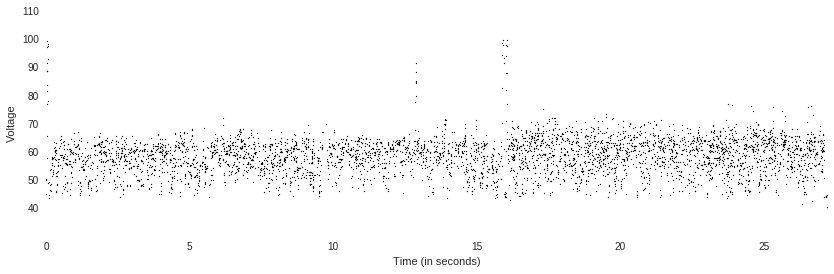

In [9]:
porekit.plots.squiggle_dots(training_data.absolute_filename[0]);

Of particular interest are the "spikes" of events. Almost every read has such a spike at the beginning of the read, and many have another one where the hairpin is translocated. We assume that we don't run into the hairpin, since we want to use only 200 events from the start of the read, and all our reads have a template strand longer than 500 bases. But we will try to minimize the effects of these outliers when normalizing the data.

## Data Normalization

Normalizing input data is important for three reasons:
* Neural Networks, and many other algorithms, work better on data centered around 0, with a standard deviation of 1
* Features with different scales can end up distorting the results (not a problem here)
* Nanopore events do have different shift, drift and scale parameters varying accross pores and reads

The Metrichor platform stores values for shift, drift and scale in the Fast5 files. But these values are estimated from an HMM during/before basecalling. In a Read Until application, we must not depend on that data.

We also can't depend on event data beyond the "horizon" of 200 events from the start.

The strategy chosen here is one among many possibilities. To evaluate different strategies is left as an exercise to the reader ;-)

In [113]:
def normalize_input(fn, n=200):
    fast5 = porekit.Fast5File(fn)
    events = fast5.get_events()
    fast5.close()
    means = events["mean"][:n]
    emin, emax = np.percentile(means, (10,90))
    cevents = means[(means>emin) & (means<emax)]
    estd = cevents.std()
    emean = cevents.mean()
    normalized = (means-emean) / estd
    normalized[normalized<-3]=-3
    normalized[normalized>3]=3
    return normalized

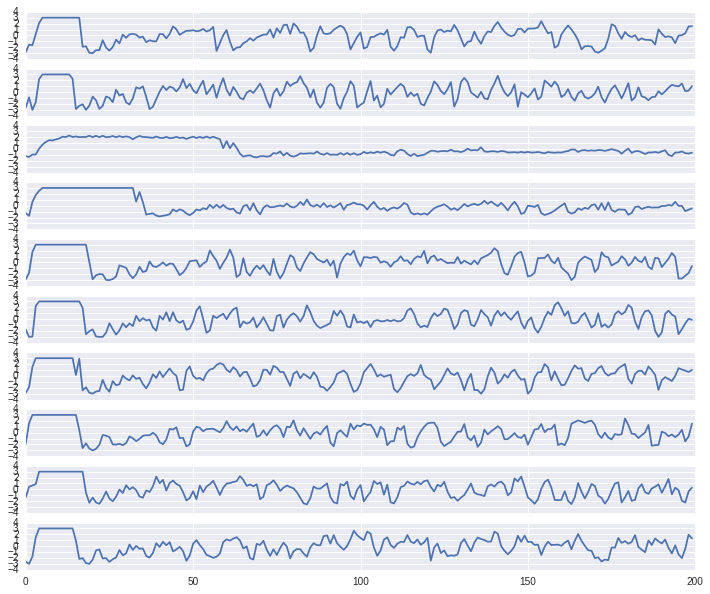

In [114]:
m = 10
f.suptitle("Normalized Event Data")
f, axes = plt.subplots(m, sharex=True)
f.set_figwidth(12)
f.set_figheight(10)
for i,fn in enumerate(training_data.absolute_filename[:m]):
    ax = axes[i]
    ax.set_ylim(-4,4)
    normalized = normalize_input(fn,200)
    ax.plot(normalized);

The ideal normalizer would create squiggles which all seam to be coming from the same kind of random process.

Even though the normalization method tries to ignore the abasic start segment, there are some reads where it dominates the standard deviation and thus scales down the signal. In this setup this probably can't be completely avoided.

It may be advantageous to use a constant value for scaling, or at least avoid extreme values. Feel free to investigate!

## It's getting even weirder

Now, in theory, if every kmer has a reference value, which is independent of its position in the read, we should expect a narrow band around 0.

Well...

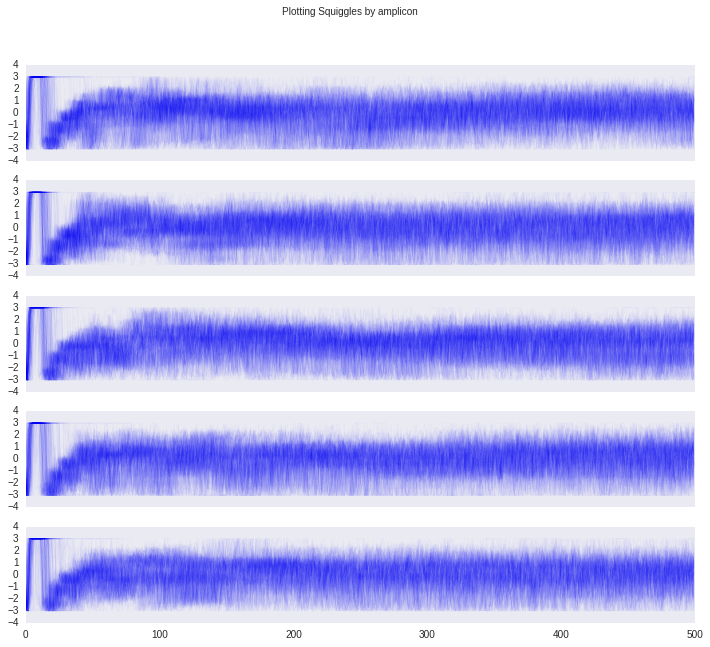

In [133]:
n = 5
f, axes = plt.subplots(n, sharex=True)
f.suptitle("Plotting Squiggles by amplicon")
f.set_figwidth(12)
f.set_figheight(10)
m = 200
for i in range(n):
    sub = training_data.query("amplicon==%i" % i)
    ax = axes[i]
    ax.grid(b=False)
    ax.set_ylim(-4,4)
    for fn in sub[:m].absolute_filename.values:
        normalized = normalize_input(fn,500)
        ax.plot(normalized, color="b", alpha=0.02,  linewidth=1);

This plot compares normalized squiggles from 5 different amplicons with each other by thinly plotting them over each other. In theory the whole plot should look like the second half. Instead there is first the abasic "outlier" part  which was clipped, and then there seems to be a strong effect of the pore starting up.

Essentially, the first 100 events seem to be especially influenced by the starting effect. In this project we will let our neural network try to use that data. For further investigations it would be interesting to see how much information can be wrought from just the first 100 events.

## Generating the dataset


The next step is to create the actual dataset, which will be two matrices: X for the features (200 events x N examples) and y for the one-hot-encoded target variable (11 x N examples). One-hot-encoding here means that instead of encoding the amplicons as 1 for amplicon 1, 2 for amplicon 2 etc, the encoded value.


In [160]:
def make_dataset(data):
    X_list, y_list = [], []
    for index, row in data.iterrows():
        x = normalize_input(row.absolute_filename).values
        X_list.append(x)
        y = np.zeros(11)
        y[int(round(row.amplicon))] = 1
        y_list.append(y)
    return np.array(X_list), np.array(y_list)

In [155]:
training_dataset = make_dataset(training_data)

(102, 200)

In [ ]:
test_X, test_y = make_dataset(test_data)
training_X, training_y = make_dataset(training_data)

Let's store this data as hdf file.

In [178]:
h5f = h5py.File("amplicon_dataset.hdf", 'w')
h5f.create_dataset('training/X', data=training_X)
h5f.create_dataset('training/y', data=training_y)
h5f.create_dataset('test/X', data=test_X)
h5f.create_dataset('test/y', data=test_y)
h5f.close()

Now it's time to work on classifiers!